In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mini_yolov3.model import MiniYoloV3
from mini_yolov3.trainer import Trainer
import torch
from torchvision.transforms import v2
from mini_yolov3.dataset import SVHNDataset, collate_fn
from torch.utils.data import Subset, DataLoader
from mini_yolov3.loss import YOLOLoss, build_targets
import matplotlib.pyplot as plt
from mini_yolov3.utils import draw_bounding_boxes
from torchvision.ops import box_convert
from mini_yolov3.evals import calculate_mAP
from torchvision.ops import box_iou
from tqdm import tqdm

/Users/ericchen/Library/Caches/pypoetry/virtualenvs/mini-yolov3-a3VRlvzj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_dataset = SVHNDataset(split="train")
# train_dataset = Subset(train_dataset, range(12, 13))
train_dataset = Subset(train_dataset, range(0, 2))

In [4]:
train_dataset[0]["bbox"]

tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])

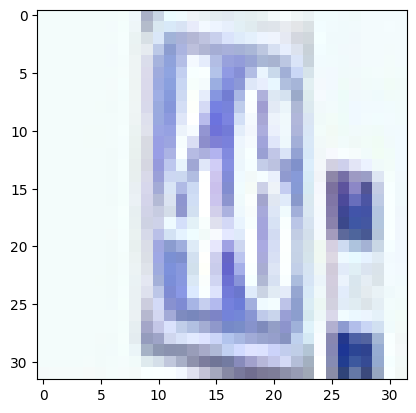

In [5]:
plt.imshow(train_dataset[0]["image"].permute(1, 2, 0))

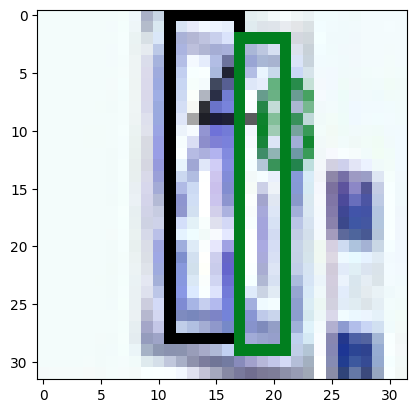

In [6]:
plt.imshow(
    draw_bounding_boxes(train_dataset[0]["image"], box_convert(train_dataset[0]["bbox"], "xywh", "xyxy"), train_dataset[0]["labels"])
)

In [7]:
dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [8]:
len(dataloader)

1

In [9]:
for batch in dataloader:
    print(batch["bboxes"])
    print(box_convert(batch["bboxes"][0], "xywh", "cxcywh"))
    targets = build_targets(batch["bboxes"], batch["labels"], (2, 2), anchors, 10)

[tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]]), tensor([[0.3443, 0.1290, 0.1967, 0.7419],
        [0.5082, 0.1613, 0.1639, 0.7419]])]
tensor([[0.4533, 0.4565, 0.1963, 0.8696],
        [0.6075, 0.5000, 0.1495, 0.8696]])


NameError: name 'anchors' is not defined

In [10]:
batch["images"].shape

torch.Size([2, 3, 32, 32])

In [11]:
import json

In [61]:
torch.manual_seed(0)

config = json.load(open("./configs/experiment2.json", "r"))
model = MiniYoloV3(**config)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    num_epochs=100,
    lr=3e-3,
    batch_size=64,
    lambda_coord=0.05,
    lambda_conf=1.0,
    lambda_cls=0.5,
    device="cpu",
    eval_every=100000,
)

100%|██████████| 100/100 [00:10<00:00,  9.94it/s, class_loss=0.000488, conf_loss=0.00181, coord_loss=6.02e-5, loss=0.00236]


[3.3803396224975586,
 3.0887842178344727,
 2.800337791442871,
 2.5605335235595703,
 2.3436484336853027,
 2.1541924476623535,
 1.9850612878799438,
 1.8269903659820557,
 1.680600643157959,
 1.5488566160202026,
 1.4270097017288208,
 1.3160488605499268,
 1.2091923952102661,
 1.1072406768798828,
 1.0093848705291748,
 0.9145103693008423,
 0.7377140522003174,
 0.5873351097106934,
 0.5009560585021973,
 0.4480741024017334,
 0.4183720648288727,
 0.3943926692008972,
 0.3668343126773834,
 0.33137980103492737,
 0.2975577116012573,
 0.2640085816383362,
 0.23863500356674194,
 0.21849507093429565,
 0.2004234492778778,
 0.18065908551216125,
 0.1644996702671051,
 0.14991852641105652,
 0.1340044140815735,
 0.12184251844882965,
 0.11009500920772552,
 0.100420281291008,
 0.09277542680501938,
 0.08460501581430435,
 0.07730429619550705,
 0.07062586396932602,
 0.06417915970087051,
 0.05853089690208435,
 0.052720922976732254,
 0.047510694712400436,
 0.04291458800435066,
 0.038576364517211914,
 0.03523593768477

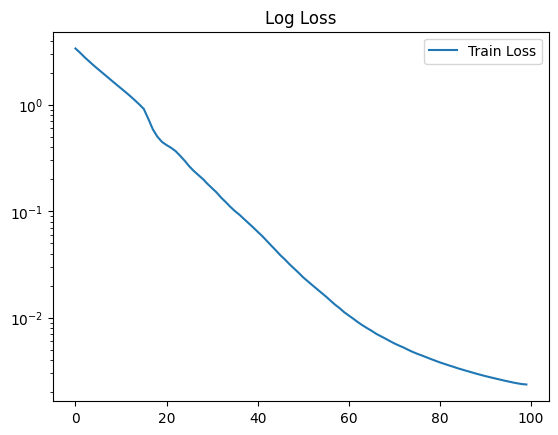

In [62]:
trainer.train()

In [63]:
pred = model(batch["images"])
pred

[tensor([[[[ 1.9864e+00, -3.4094e+00,  1.8339e+00,  2.0314e+00, -5.2635e+00,
            -2.7470e+00, -1.4851e-01,  3.8108e-01, -1.7138e+00, -2.5843e+00,
            -2.2030e+00,  4.4161e-01, -2.3455e-01, -3.0300e+00, -4.2237e-01],
           [ 8.8459e-01, -4.0527e+00,  1.5520e+00,  1.8530e+00, -5.9323e+00,
            -2.8984e+00, -7.0252e-01, -6.6874e-01, -2.4011e+00, -2.1844e+00,
            -2.1331e+00,  2.5743e-01,  5.9946e-01, -4.1941e+00,  7.5136e-02],
           [ 5.3321e+00, -3.8491e+00,  3.2245e+00,  3.6206e+00, -6.7067e+00,
            -4.0757e+00,  7.6546e-01,  2.4987e+00, -1.2869e+00, -4.6123e+00,
            -3.6979e+00,  1.1313e+00, -1.9449e+00, -2.3849e+00, -1.5057e+00],
           [-1.0322e+00, -3.9448e+00,  9.0028e-01,  1.0177e+00, -5.2789e+00,
            -2.1689e+00, -1.2352e+00, -1.8164e+00, -2.8280e+00, -1.1964e+00,
            -1.2806e+00, -5.3025e-03,  1.6664e+00, -4.8024e+00,  6.8524e-01]],
 
          [[-2.0435e+00, -4.3804e+00,  3.1125e-01,  4.5556e-01, -4.86

In [68]:
i = 1

In [69]:
output = model.inference(
    batch["images"],
)

bounding_boxes = output.bboxes
bounding_boxes

[{'bboxes': tensor([[0.4523, 0.4548, 0.1983, 0.8641],
          [0.6087, 0.5000, 0.1484, 0.8549]]),
  'confidence': tensor([1.0000, 0.9987]),
  'labels': tensor([4, 6]),
  'scores': tensor([1.0000, 0.9999])},
 {'bboxes': tensor([[0.5898, 0.5327, 0.1636, 0.7502],
          [0.4419, 0.5000, 0.1986, 0.7514]]),
  'confidence': tensor([1.0000, 0.9960]),
  'labels': tensor([1, 7]),
  'scores': tensor([1.0000, 1.0000])}]

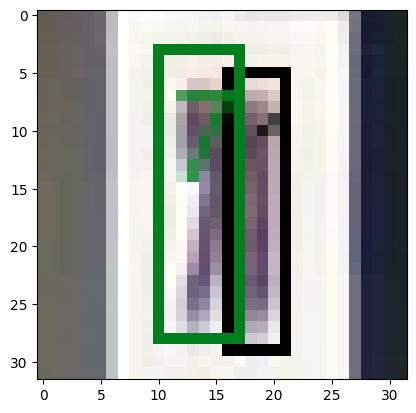

In [70]:
plt.imshow(
    draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
)
)

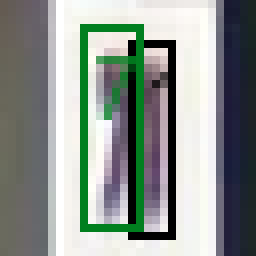

In [71]:
draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
).resize((256, 256), 0)

In [22]:
calculate_mAP(
    model,
    trainer.train_loader,
)

{'map': 0.0,
 'map_50': 0.0,
 'map_75': 0.0,
 'map_small': 0.0,
 'map_medium': -1.0,
 'map_large': -1.0,
 'mar_1': 0.0,
 'mar_10': 0.0,
 'mar_100': 0.0,
 'mar_small': 0.0,
 'mar_medium': -1.0,
 'mar_large': -1.0,
 'map_per_class': -1.0,
 'mar_100_per_class': -1.0,
 'classes': [1, 4, 6, 7]}